<a href="https://colab.research.google.com/github/gizemkaratas/Miuul_ML_FinalProjesi/blob/main/asist_BitirmeProjesi_miuul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Makine Öğrenmesi ile Futbol Maç Sonucu Tahminlemesi**

## **Projenin Konusu ve Hedefi**

*  Bu projede, futbol maçlarında oyuncuların sarı kart görme olasılığını etkileyen faktörleri analiz edilerek ve bu bilgiler doğrultusunda gelecekteki maçlar için sarı kart tahminleme modeli oluşturuldu.
 İlk aşamada, oyuncuların yaşı, pozisyonu, oynadığı takım, teknik direktör, sahada kaldığı süre, maçın oynandığı stadyum, seyirci sayısı, maçın önemi ve hakem gibi değişkenleri dikkate alarak sarı kart görme olasılıklarını değerlendirildi.
 Bu analiz kapsamında, sarı kart görme eğilimlerini anlamak için keşifsel veri analizi ve görselleştirme tekniklerini kullanıldı. Elde edilen bulgular doğrultusunda, makine öğrenimi algoritmalarıyla gelecekteki maçlarda hangi oyuncuların sarı kart göreceğini tahmin eden bir model geliştirildi.
 Bu model, futbol kulüpleri ve teknik direktörler için oyuncu performansını optimize etmek, maç stratejilerini geliştirmek ve disiplin sorunlarını önceden tahmin ederek gerekli önlemleri almak konusunda önemli bir araç olarak kullanılabilir. Proje, futbol analitiği alanında yenilikçi bir yaklaşım sunarak veri odaklı karar alma süreçlerini desteklemeyi amaçlamaktadır.



**Gerekli Kütüphanelerin Yüklenmesi ve Ayarların Yapılması**

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
from sklearn.exceptions import ConvergenceWarning

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

**Veri Setlerinin Yüklenmesi ve Dataframe Düzenlenmesi**

*   Birden fazla csv dosyasından alınan verilerin birleştirilmesi ve dflerin içinde gerekli olan columnların seçilmesi işlemi gerçekleştirildi.




In [54]:
# prompt: drive dosyasına erişsin

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# "appearances.csv" dosyasını okur ve "date" sütununu tarih formatında dönüştürür
app = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/appearances.csv", parse_dates=["date"])
# Sadece gerekli sütunları seçer: "game_id", "date", "player_id", "yellow_cards" ve "minutes_played"
app = app.loc[:, ["game_id", 'date', 'player_id', "yellow_cards", 'minutes_played']]

pl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/players.csv", parse_dates=["date_of_birth"])
pl = pl.loc[:, ['player_id', 'date_of_birth', 'position']]
# Eksik verileri (NaN) içeren satırları kaldırır
pl = pl.dropna()

g = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/games.csv")
g = g.loc[:, ['game_id', 'stadium', 'attendance', 'referee', 'competition_type']]
g = g.dropna()

ge = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/game_events.csv", parse_dates=["date"])
ge = ge.loc[:, ['game_id', 'date', 'minute', 'type', 'player_id', 'description']]
ge = ge.dropna()

cl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/clubs.csv")
cl = cl.loc[:, ['stadium_name', 'stadium_seats']]
# "stadium_name" sütununu "stadium" olarak yeniden adlandırır
cl = cl.rename(columns={"stadium_name": "stadium"})


**Veri Birleştirme**

In [56]:
# "ge" (game_events) ve "g" (games) DataFrame'lerini "game_id" sütunu üzerinden birleştirilmesi
df = pd.merge(ge, g, on='game_id', how='inner')

# Elde edilen DataFrame'i, "pl" (players) DataFrame'i ile "player_id" sütunu üzerinden birleştirilmesi
df = pd.merge(df, pl, on='player_id', how='inner')

# Sonuç DataFrame'ini, "app" (appearances) DataFrame'i ile "game_id", "date" ve "player_id" sütunları üzerinden birleştirilmesi
df = df.merge(app, on=['game_id', "date", "player_id"], how='inner')

# Sonuç DataFrame'ini, "cl" (clubs) DataFrame'i ile "stadium" sütunu üzerinden birleştirilmesi
df = df.merge(cl, on='stadium', how='inner')


**Veri Temizleme**

In [57]:
# Verideki hatalı veya sorun çıkaran kısımların çıkarılması
df = df[df["minute"] >= 0]
df = df[~(df["position"] == "Missing")]
df["attendance"] = df["attendance"].astype("int")


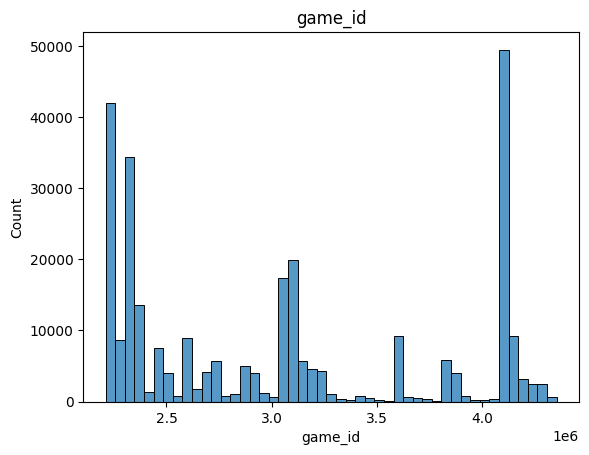

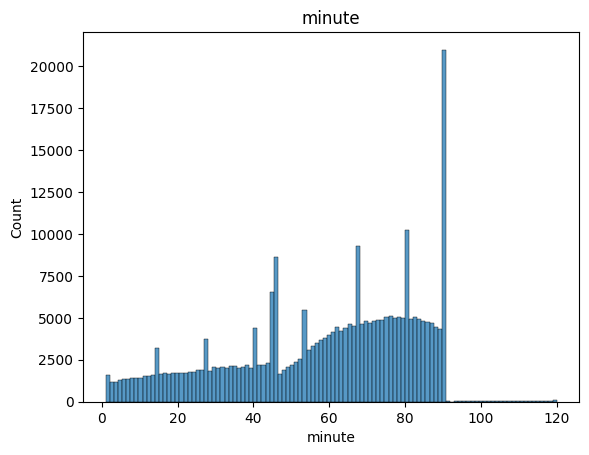

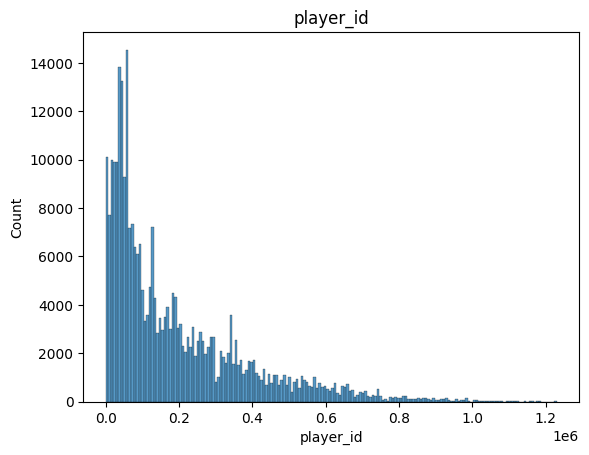

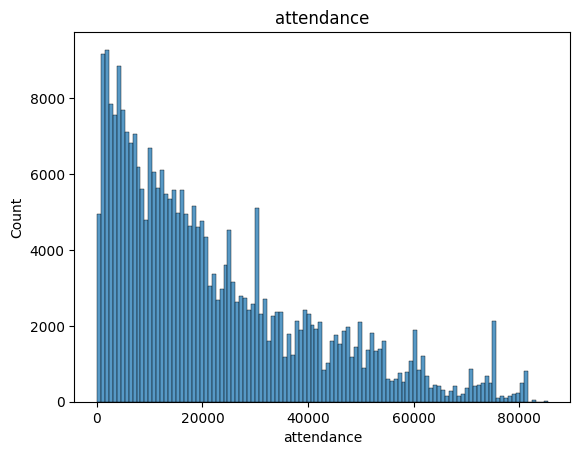

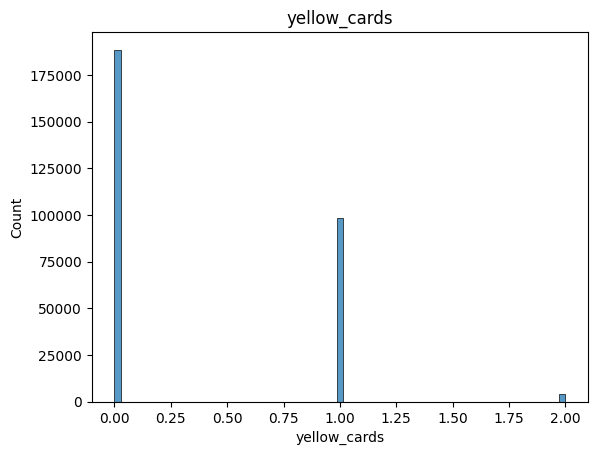

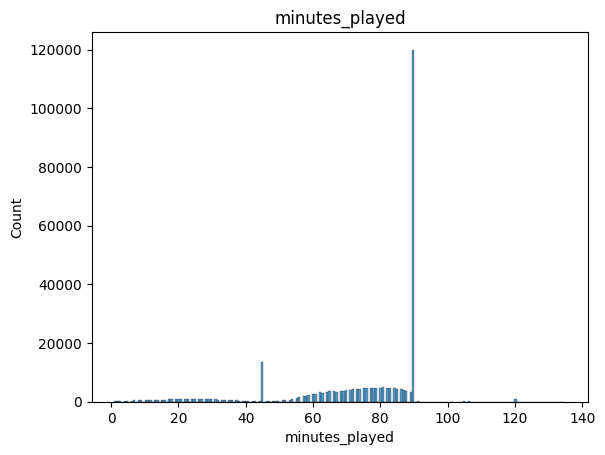

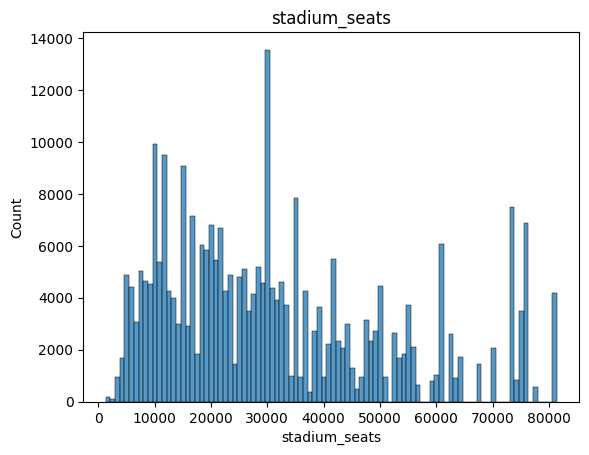

In [58]:
# prompt: grafik oluştur sütun hariç ve pozisyon hariç

import matplotlib.pyplot as plt
# 'position' ve 'sütun' sütunları hariç tüm sayısal sütunlar için histogramlar oluştur
for col in df.select_dtypes(include=['number']).columns:
  if col not in ['position', 'sütun']:  # 'sütun' yerine gerçek sütun adını kullanın
    plt.figure()
    sns.histplot(df[col])
    plt.title(col)
    plt.show()


**Yeni Değişken Oluşturma**

In [59]:
# Yeni değişkenler eklenmesi(ilk-son20 dk ve uzatmalar için)
df["last_20"] = [1 if ((i[2] >= 70 and i[2] <= 90) & (i[3] == "Cards")) else 0 for i in df.values]
df["first_20"] = [1 if ((i[2] <= 20 ) & (i[3] == "Cards")) else 0 for i in df.values]
df["extras"] = [1 if ((i[2] > 90 ) & (i[3] == "Cards")) else 0 for i in df.values]

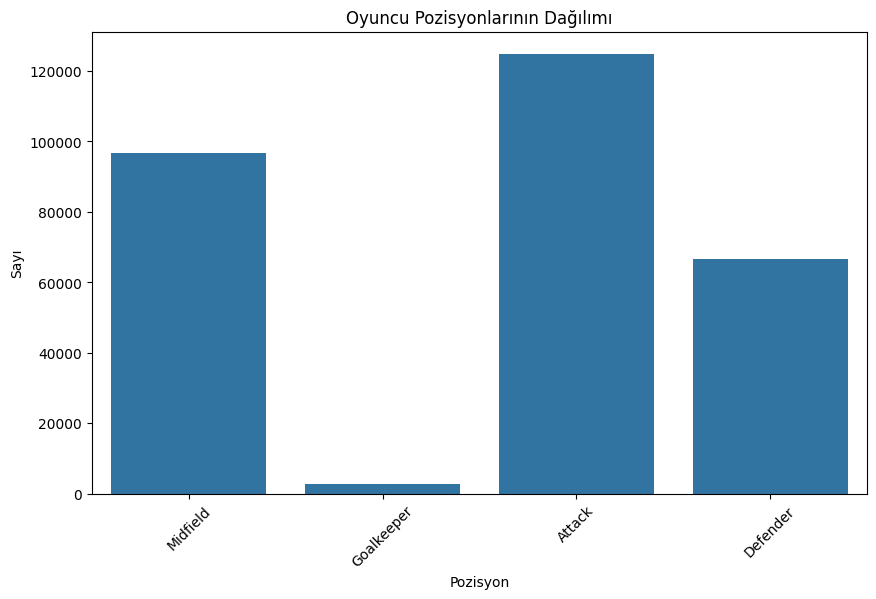

In [60]:
# prompt: grafik görsel ekle

import matplotlib.pyplot as plt
# Örnek bir grafik ekleme
plt.figure(figsize=(10, 6))
sns.countplot(x='position', data=df)
plt.title('Oyuncu Pozisyonlarının Dağılımı')
plt.xlabel('Pozisyon')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()


**Düzenleme**

In [61]:
# Her stadyumun maksimum kapasitesini hesaplar
max_capacity_df = cl.groupby('stadium')['stadium_seats'].max().reset_index()

# max_capacity_df'yi cl DataFrame'i ile birleştirir
cl = cl.merge(max_capacity_df, on='stadium', how='inner', suffixes=('', '_max'))

# stadium_seats_max sütununa sahip duplicate kayıtları kaldırır
cl = cl.drop_duplicates(subset=['stadium', 'stadium_seats_max'])
# df ve cl DataFrame'lerini stadium sütunu üzerinden birleştirir
df = df.merge(cl[['stadium', 'stadium_seats_max']], on='stadium', how='inner')
# Oyuncunun yaşını hesaplar
df['age'] = df['date'].dt.year - df['date_of_birth'].dt.year
# Doluluk oranını hesaplar
df["attendance_rate"] = (df["attendance"] * 100) / df["stadium_seats_max"]

# Doluluk oranını 100'den büyük olanları filtreler
df = df[df["attendance_rate"] <= 100.0]
# Hakemlerin sarı kart ortalamasını hesaplar
referee_card_avg = df.groupby('referee')['yellow_cards'].mean().reset_index()
referee_card_avg.columns = ['referee', 'referee_card_avg']

# Sarı kart ortalamasını df ile birleştirir
df = df.merge(referee_card_avg, on='referee', how='inner')
# Maçların önemine göre değer ataması yapar
importance_mapping = {
    'domestic_league': 1,
    'domestic_cup': 2,
    'international_cup': 3,
    'others': 0
}
df['importance'] = df['competition_type'].apply(lambda x: importance_mapping.get(x, 0))
# Oyuncuların yaşlarına göre deneyim değeri atar
bins = [15, 24, 33, 42]
labels = [1, 2, 3]
df['experience'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df['experience'] = df['experience'].astype('int')


In [63]:
#Veri setindeki kullanılmayacak columnların temizlenmesi
df = df.drop(['game_id', 'date', 'type', 'minute','description', 'date_of_birth','stadium_seats',
       'stadium_seats_max', 'competition_type', 'stadium'], axis=1)
df.to_csv('output.csv', index=False)


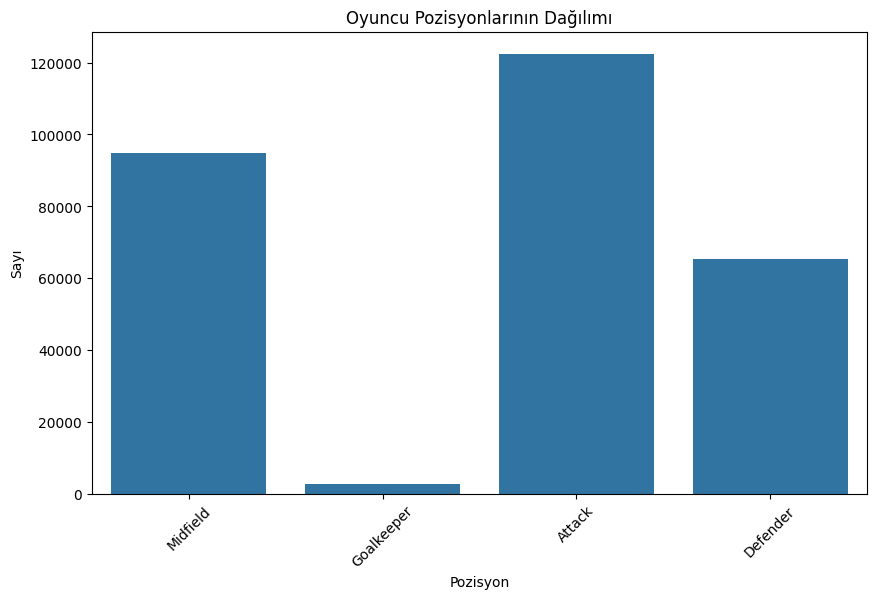

In [64]:
# prompt: görsel grafik ekle

import matplotlib.pyplot as plt
# Örnek bir grafik ekleme
plt.figure(figsize=(10, 6))
sns.countplot(x='position', data=df)
plt.title('Oyuncu Pozisyonlarının Dağılımı')
plt.xlabel('Pozisyon')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()


**Veri Önizleme**

In [65]:
def check_df(dataframe):
    print("##################### Boyut #####################")
    print(dataframe.shape)
    print("##################### Türler #####################")
    print(dataframe.dtypes)
    print("##################### İlk 3 Kayıt #####################")
    print(dataframe.head(3))
    print("##################### Son 3 Kayıt #####################")
    print(dataframe.tail(3))
    print("##################### Eksik Değerler #####################")
    print(dataframe.isnull().sum())
    print("##################### Yüzdelikler #####################")
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)


##################### Boyut #####################
(285102, 15)
##################### Türler #####################
player_id               int64
attendance              int64
referee                object
position               object
yellow_cards            int64
minutes_played          int64
last_20                 int64
first_20                int64
extras                  int64
age                     int32
attendance_rate       float64
referee_card_avg_x    float64
importance              int64
experience              int64
referee_card_avg_y    float64
dtype: object
##################### İlk 3 Kayıt #####################
   player_id  attendance        referee  position  yellow_cards  \
0       4425       50000  Björn Kuipers  Midfield             1   
1       4425       50965  Björn Kuipers  Midfield             1   
2       4425       50965  Björn Kuipers  Midfield             1   

   minutes_played  last_20  first_20  extras  age  attendance_rate  \
0              90        1 

**Kategorik Değişkenlerin Belirlenmesi**



In [66]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f'Kategorik Sütunlar: {len(cat_cols)}')
    print(f'Sayısal Sütunlar: {len(num_cols)}')
    print(f'Yüksek Kardinaliteli Kategorik Sütunlar: {len(cat_but_car)}')
    print(f'Sayısal Görünen Kategorik Sütunlar: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Gözlemler: 285102
Değişkenler: 15
Kategorik Sütunlar: 7
Sayısal Sütunlar: 7
Yüksek Kardinaliteli Kategorik Sütunlar: 1
Sayısal Görünen Kategorik Sütunlar: 6


In [67]:
# prompt: görsel grafik ekle

import plotly.express as px

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


**Değişken Analizi**

            HEDEF_ORTALAMA
position                  
Attack               0.233
Defender             0.557
Goalkeeper           0.727
Midfield             0.396


              HEDEF_ORTALAMA
yellow_cards                
0                      0.000
1                      1.000
2                      2.000


         HEDEF_ORTALAMA
last_20                
0                 0.296
1                 1.025


          HEDEF_ORTALAMA
first_20                
0                  0.352
1                  1.018


        HEDEF_ORTALAMA
extras                
0                0.365
1                1.043


            HEDEF_ORTALAMA
importance                
0                    0.305
1                    0.370
2                    0.318
3                    0.345


            HEDEF_ORTALAMA
experience                
1                    0.348
2                    0.374
3                    0.387


              player_id
yellow_cards           
0            194630.895
1            182269.73

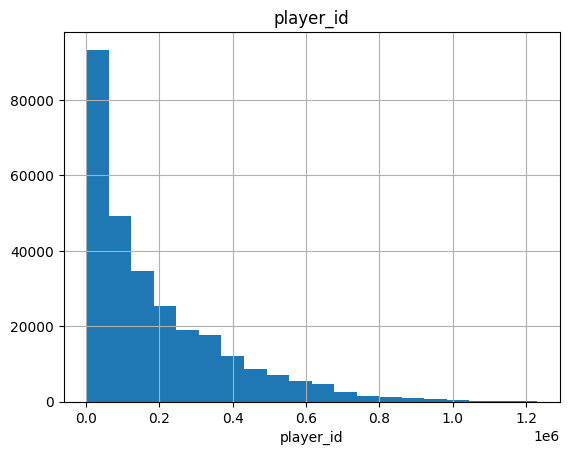

count   285102.000
mean     21717.588
std      18397.628
min         23.000
5%        1528.000
10%       2769.000
20%       5500.000
30%       8713.000
40%      12465.000
50%      16411.000
60%      21000.000
70%      27819.000
80%      36934.000
90%      49943.000
95%      60000.000
99%      75000.000
max      81365.000
Name: attendance, dtype: float64


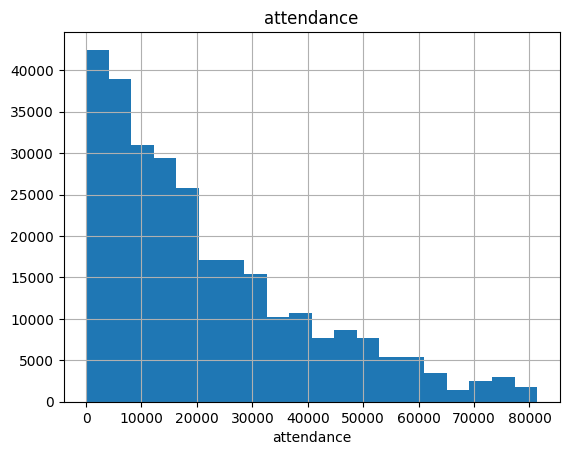

count   285102.000
mean        74.938
std         20.589
min          1.000
5%          26.000
10%         45.000
20%         62.000
30%         71.000
40%         77.000
50%         83.000
60%         90.000
70%         90.000
80%         90.000
90%         90.000
95%         90.000
99%         90.000
max        135.000
Name: minutes_played, dtype: float64


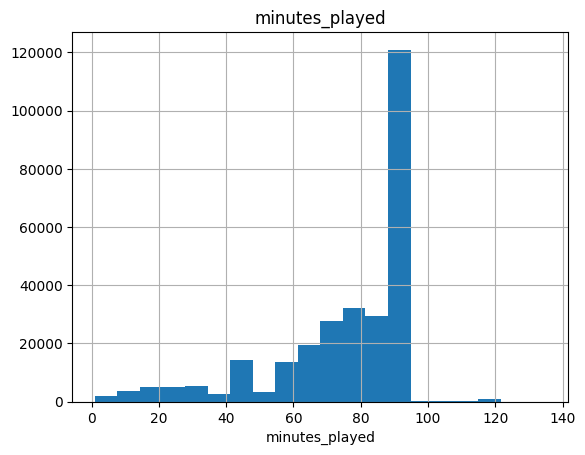

count   285102.000
mean        26.455
std          4.074
min         15.000
5%          20.000
10%         21.000
20%         23.000
30%         24.000
40%         25.000
50%         26.000
60%         27.000
70%         29.000
80%         30.000
90%         32.000
95%         34.000
99%         36.000
max         42.000
Name: age, dtype: float64


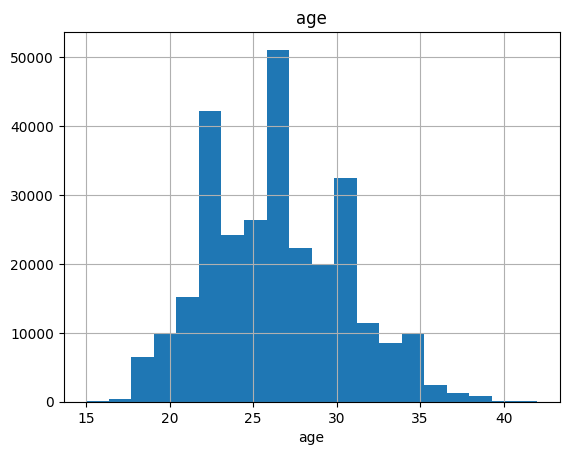

count   285102.000
mean        63.512
std         28.309
min          0.069
5%          12.923
10%         20.782
20%         34.573
30%         47.244
40%         57.436
50%         68.020
60%         77.536
70%         85.635
80%         92.987
90%         97.695
95%         99.321
99%        100.000
max        100.000
Name: attendance_rate, dtype: float64


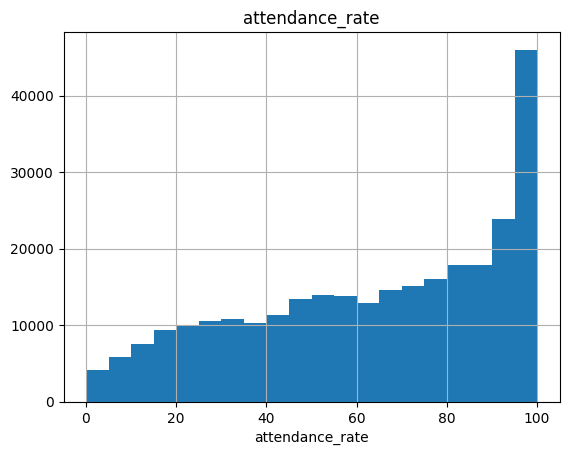

count   285102.000
mean         0.366
std          0.084
min          0.000
5%           0.254
10%          0.272
20%          0.299
30%          0.320
40%          0.337
50%          0.356
60%          0.380
70%          0.404
80%          0.432
90%          0.475
95%          0.511
99%          0.604
max          1.000
Name: referee_card_avg_x, dtype: float64


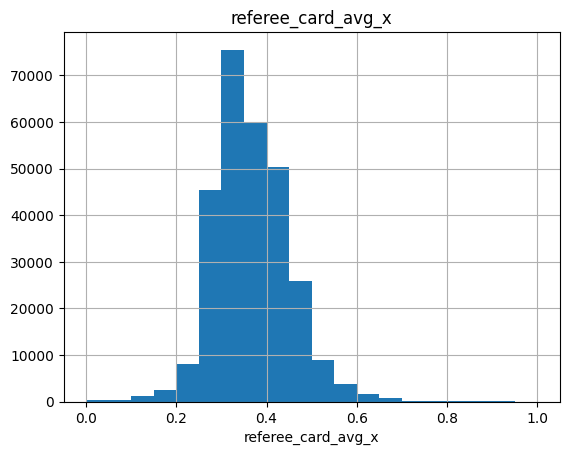

count   285102.000
mean         0.366
std          0.084
min          0.000
5%           0.254
10%          0.272
20%          0.299
30%          0.320
40%          0.337
50%          0.356
60%          0.380
70%          0.404
80%          0.432
90%          0.475
95%          0.511
99%          0.604
max          1.000
Name: referee_card_avg_y, dtype: float64


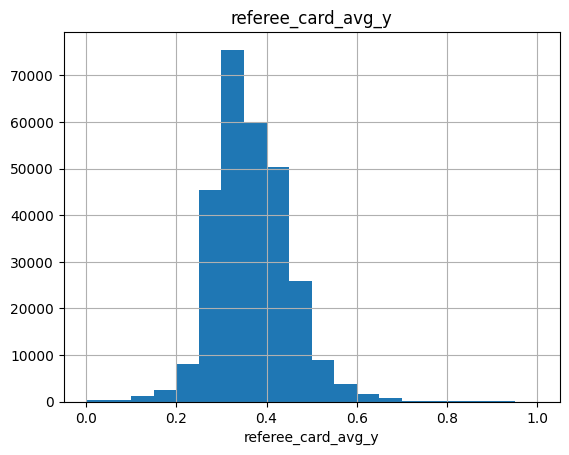

            position  Ratio
position                   
Attack        122513 42.972
Midfield       94738 33.230
Defender       65240 22.883
Goalkeeper      2611  0.916
##########################################


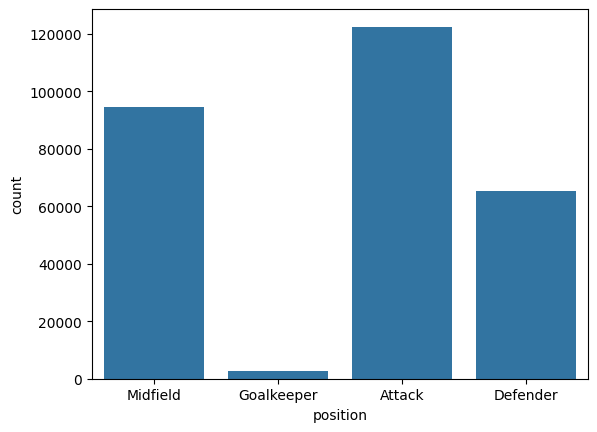

              yellow_cards  Ratio
yellow_cards                     
0                   184887 64.849
1                    96176 33.734
2                     4039  1.417
##########################################


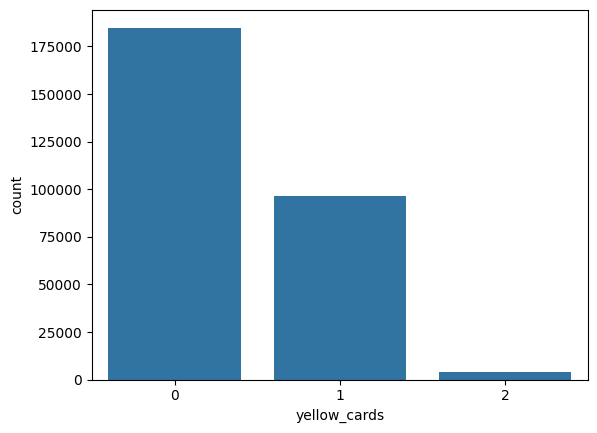

         last_20  Ratio
last_20                
0         257927 90.468
1          27175  9.532
##########################################


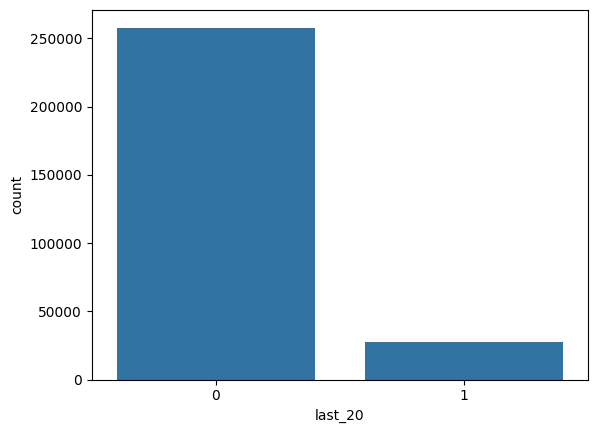

          first_20  Ratio
first_20                 
0           279246 97.946
1             5856  2.054
##########################################


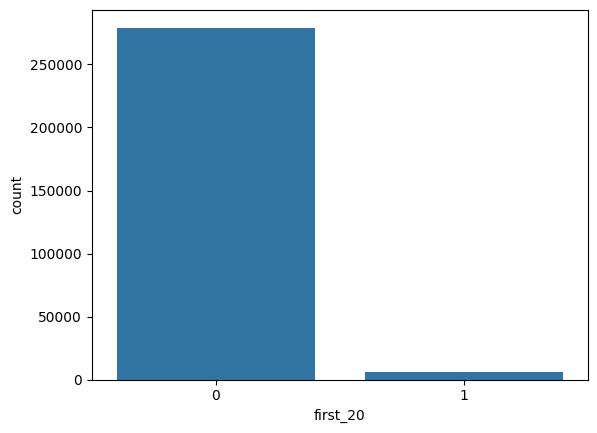

        extras  Ratio
extras               
0       284870 99.919
1          232  0.081
##########################################


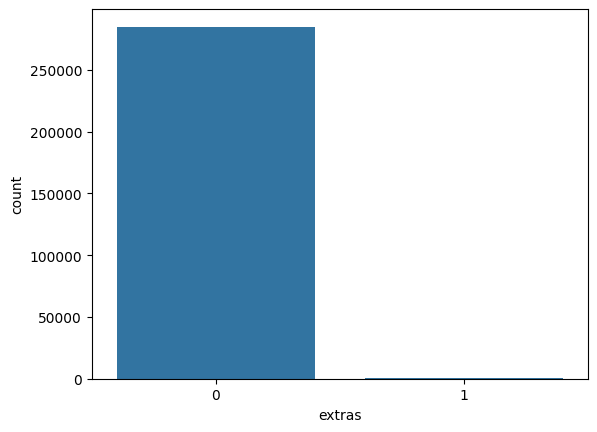

            importance  Ratio
importance                   
1               251851 88.337
3                17636  6.186
2                14783  5.185
0                  832  0.292
##########################################


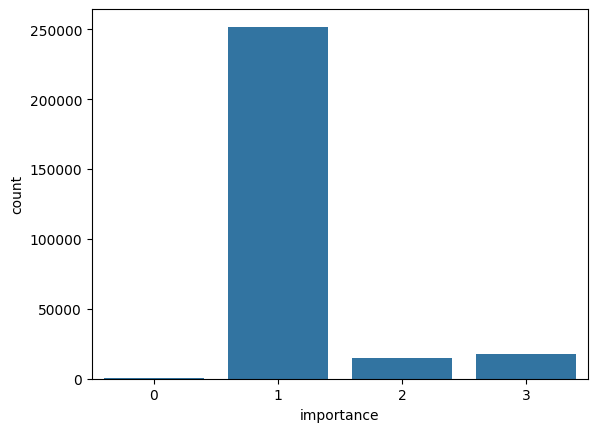

            experience  Ratio
experience                   
2               172014 60.334
1                98376 34.506
3                14712  5.160
##########################################


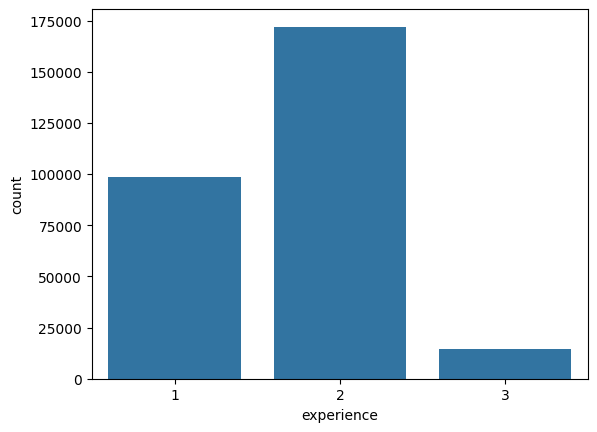

In [68]:
# Kategorik değişkenlerin hedef değişken ile ilişkisinin incelenmesi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"HEDEF_ORTALAMA": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "yellow_cards", col)

# Sayısal değişkenlerin hedef değişken ile ilişkisinin incelenmesi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "yellow_cards", col)

# Sayısal değişkenlerin özeti ve görselleştirilmesi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)
    # Kategorik değişkenlerin özeti ve görselleştirilmesi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].
                        value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

In [69]:
# prompt: görsel grafik ekle

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


**Korelasyon Analizi**

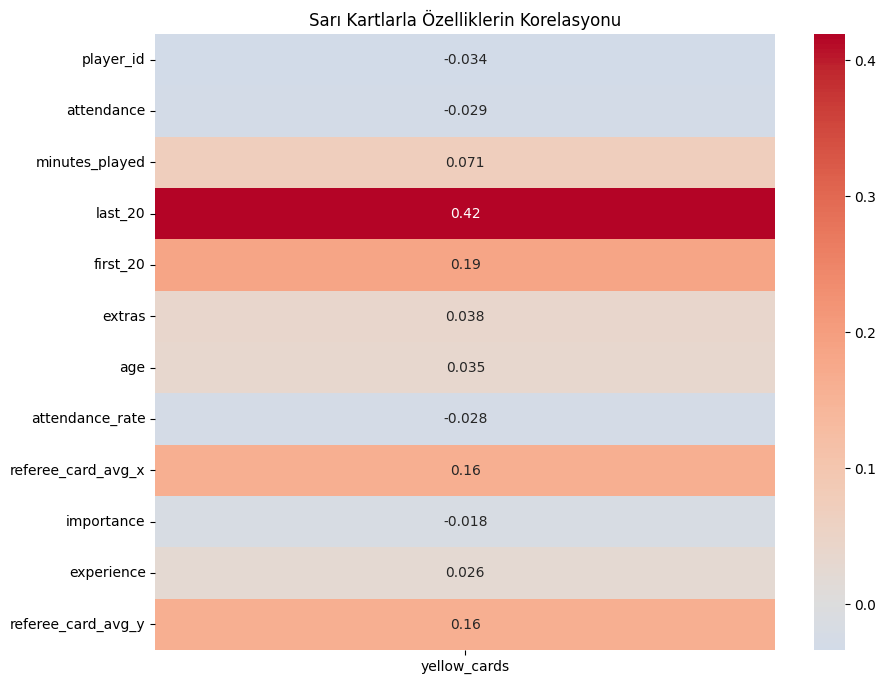

In [70]:
# Korelasyon analizi ve görselleştirme
data = df.copy()
data = data.drop(columns=['referee', 'position'])

# Korelasyon matrisini hesaplama
correlation_matrix = data.corr()

# Sadece yellow_cards ile korelasyonları alma
yellow_card_correlations = correlation_matrix['yellow_cards'].drop('yellow_cards')

# Korelasyonları görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(yellow_card_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Sarı Kartlarla Özelliklerin Korelasyonu')
plt.show()


In [71]:
# prompt: görsel grafik ekle

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


**Görselleştirmeler**

In [72]:
# 3. Hakemlerin sarı kart verme ortalamasına göre sarı kart dağılımı
plt.figure(figsize=(10, 6))
sns.boxplot(x='yellow_cards', y='referee_card_avg', data=df)
plt.title('Hakemlerin Sarı Kart Verme Ortalamasına Göre Sarı Kart Dağılımı')
plt.xlabel("Sarı Kart Sayısı")
plt.ylabel("Hakemin Sarı Kart Verme Ortalaması")
plt.show()

# 4. Maç doluluk oranına göre sarı kart ortalaması
attendance_rate_mean_yellow_cards = df.groupby('attendance_rate')['yellow_cards'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='attendance_rate', y='yellow_cards', data=attendance_rate_mean_yellow_cards)
plt.title('Maç Doluluk Oranına Göre Sarı Kart Ortalaması')
plt.xlabel("Maç Doluluk Oranı (%)")
plt.ylabel("Sarı Kart Ortalaması")
plt.show()

# 6. Mevkine göre sarı kart ortalaması
position_mean_yellow_cards = df.groupby('position')['yellow_cards'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='position', y='yellow_cards', data=position_mean_yellow_cards)
plt.title('Mevkine Göre Sarı Kart Ortalaması')
plt.xlabel("Mevki")
plt.ylabel("Sarı Kart Ortalaması")
plt.show()


ValueError: Could not interpret value `referee_card_avg` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [ ]:
# prompt: görsel grafik ekle

# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()


In [ ]:
# prompt: bir tane daha grafik ekle

import matplotlib.pyplot as plt
# Örnek bir görsel grafik ekleme
fig = px.scatter(df, x='minutes_played', y='yellow_cards', color='position',
                 title='Oyun Süresi ve Sarı Kart İlişkisi',
                 labels={'minutes_played': 'Oyun Süresi (dakika)', 'yellow_cards': 'Sarı Kart Sayısı'})
fig.show()

# Oyuncuların yaş dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Oyuncuların Yaş Dağılımı')
plt.xlabel('Yaş')
plt.ylabel('Sayı')
plt.show()
